In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "2"


In [1]:
import h5py
import numpy as np
import scipy.ndimage
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

import time

import matplotlib.pyplot as plt

In [2]:
# this should be 2.6 or later
print(tf.__version__)

2.4.1


# Load in data

In [4]:
filename = "../../sim2_z3_FGPA_cgs.h5"
tf_filename = "../lya_fields/results/tf_fields1x1x1024.h5"

h5 = h5py.File(filename,'r')
tf_h5 = h5py.File(tf_filename,'r')

# full fields
DM_dens = h5['native_fields']['matter_density'][()] # rho
baryon_dens = h5['native_fields']['baryon_density'][()] # rho_b
temperature = h5['native_fields']['temperature'][()] # T

treal = tf_h5['tau_real'][()] # real-space optical depth (lya-tf)
treal_g = h5['derived_fields']['tau_real'][()] # real-space optical depth (Gimlet)

h5.close()
tf_h5.close()

## Gaussian filter function
In the (differentiable) optimization process, `gaussian_blur` replaces scipy.ndimage.gaussian_filter.

In [5]:
def gaussian_blur(img, kernel_size, sigma):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    img = tf.reshape(img, [1, img.shape[-2], img.shape[-1], 1]) # e.g. (1, 1024, 1024, 1)
    
    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    gaussian_kernel = tf.cast(gaussian_kernel, 'float64')

    result = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    return result

# Fit the DM-to-baryon formulas

Let $\rho$ be the ratio of dark matter density to the mean DM density, and let $\rho_b$ be the same for baryons. Let $\sigma_T$ and $\sigma_\rho$ be the smoothing scales for temperature and baryon density, respectively.

Baryon temperature:
$$T = T_0 [\text{gaussian_smoothing}(\rho, \sigma_T)]^{\gamma_T-1} $$
Baryon density:
$$\rho_b = \rho_{b,0} [\text{gaussian_smoothing}(\rho, \sigma_\rho)]^{\gamma_\rho-1} $$

In [6]:
# train on one part of the snapshot
train_inds = (512,
              slice(0, 1024),
              slice(0, 1024))
rho_train = DM_dens[train_inds]
rhob_train = baryon_dens[train_inds]
temp_train = temperature[train_inds]

# test on one skewer
test_inds = (0, 0, slice(0, 1024))
rho_test = DM_dens[test_inds]
rhob_test = baryon_dens[test_inds]
temp_test = temperature[test_inds]

rho_train = tf.cast(rho_train, 'float64')

2021-09-18 00:43:33.552135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-18 00:43:34.573459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:1f:00.0, compute capability: 7.0


In [7]:
def bary_model(rho, x0, sigma, gamma):
    '''
    The model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    return x0 * (scipy.ndimage.gaussian_filter(rho, sigma))**(gamma - 1)

def bary_model_diff(rho, x0, sigma, gamma):
    '''
    The (differentiable) model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    result = x0 * (gaussian_blur(rho, sigma*2, sigma))**(gamma - 1)
    return tf.squeeze(result)

def obj_fn(params, x):
    '''
    The objective function to be minimized for fitting. 
    
    PARAMETERS
    ----------
    params: (x0, sigma, gamma)
    x: the baryon property to fit, either 'rho' (baryon density) or 't' (temperature)
    
    '''
    
    x0, sigma, gamma = params
    
    x_pred = bary_model_diff(rho_train, x0, sigma, gamma)
    
    if x == 'rho':
        return np.mean(np.square(rhob_train - x_pred))
    elif x == 't':
        return np.mean(np.square(temp_train - x_pred))
    else:
        raise ValueError("Invalid argument: x must be either 'rho' or 't'")
        
def obj_fn_logT(params):
    '''
    The objective function to be minimized for fitting log(T). When using scipy.optimize.minimize,
    fitting log(T_0) may yield better results than fitting T_0, but it's much slower (on the order
    of tens of minutes for 10 iterations).
    
    PARAMETERS
    ----------
    params: (logT0, sigma, gamma)
    
    '''
    
    logT0, sigma, gamma = params
    
    logT_pred = logT0 + (gamma - 1)*np.log10(gaussian_blur(rho_train, sigma*2, sigma))
    
    return np.mean(np.square(temp_train - 10**logT_pred))

In [8]:
bary_model_diff(rho_train, 3, 1.5, 1.6).shape

2021-09-18 00:43:35.966370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


TensorShape([1024, 1024])

## testing gaussian filters

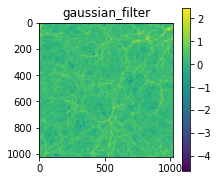

/tmp/ipykernel_111984/3713028124.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bary_model_diff(rho_train, x0, sigma, gamma)))


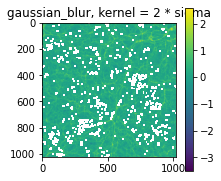

/tmp/ipykernel_111984/3713028124.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(result[0,...,0]))


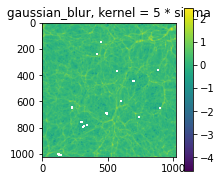

In [9]:
x0 = 3
sigma = 1.5
gamma = 1.6

# using ndimage.gaussian_filter, sigma = 1.5
plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model(rho_train, x0, sigma, gamma)))
plt.title("gaussian_filter")
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model_diff(rho_train, x0, sigma, gamma)))
plt.title("gaussian_blur, kernel = 2 * sigma")
plt.colorbar()
plt.show()

result = x0 * (gaussian_blur(rho_train, sigma*5, sigma))**(gamma - 1)
plt.figure(figsize=(3,3))
plt.imshow(np.log10(result[0,...,0]))
plt.title("gaussian_blur, kernel = 5 * sigma")
plt.colorbar()
plt.show()

## Attempt 1 (scipy.optimize.minimize, works)

This works with gaussian_blur, which is differentiable, but not gaussian_filter.

### minimizing rho_0, etc.

In [10]:
#guess = (np.mean(rhob_train), 1, 1.6) # np.mean(rhob_train) ~ 0.8
guess = (1.51538566, 3.8727029, 1.81753521) # after ~50 iterations from the initial guess

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('rho'), options = options)

         Current function value: 1.172635
         Iterations: 9
         Function evaluations: 272
         Gradient evaluations: 66


In [11]:
obj_fn(guess, 'rho')

3.799767056661308

In [12]:
result

      fun: 1.1726347301870133
 hess_inv: array([[ 0.37288337, -0.27871998, -0.06122616],
       [-0.27871998,  7.25301203,  0.07551907],
       [-0.06122616,  0.07551907,  0.01069172]])
      jac: array([ 0.29968156, -0.01091905,  2.42791173])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 272
      nit: 9
     njev: 66
   status: 2
  success: False
        x: array([0.98828643, 3.00042119, 1.94630712])

In [13]:
guess

(1.51538566, 3.8727029, 1.81753521)

### minimizing T_0, etc.

In [14]:
guess = (10000, 1, 1.6)

In [15]:
#guess = (1.26209647e+04, 1.00005124e+00, 1.41253306e+00) # after 9 iterations
guess = (1.23905759e+04, 4.00677777e+00, 1.45035417e+00) # after 7 more

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('t'), options = options)

         Current function value: 2619160.673272
         Iterations: 1
         Function evaluations: 321
         Gradient evaluations: 78


In [16]:
obj_fn(guess, 't')

2761696.3098898795

In [17]:
result

      fun: 2619160.673272172
 hess_inv: array([[ 1.00000000e+00,  1.08410017e-07, -1.30281619e-05],
       [ 1.08410017e-07,  1.00017720e+00,  4.05286314e-04],
       [-1.30281619e-05,  4.05286314e-04,  1.65381710e-07]])
      jac: array([ 1.16125000e+02,  2.24583594e+05, -1.09032100e+06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 321
      nit: 1
     njev: 78
   status: 2
  success: False
        x: array([1.23905759e+04, 4.00656521e+00, 1.46584340e+00])

## Attempt 2 (trial and error)

In [18]:
guess = (np.mean(rhob_train), np.std(rhob_train), 1.6, 'rho')
obj_fn(guess)

TypeError: obj_fn() missing 1 required positional argument: 'x'

In [22]:
# def obj_fn_vec(x0, sigma, gamma=1.6, x='rho'):
#     '''
#     A vectorized version of obj_fn.
    
#     PARAMETERS
#     ----------
#     x0, sigma, gamma: the parameters to be fitted
#     x: a string, either 'rho' (for baryon density) or 't' (for temperature)
    
#     '''
    
#     params = (x0, sigma, gamma)
#     return obj_fn(params, x)

# obj_fn_vec(0.8, 4.5, 2, 'rho')

### adjusting x0 and sigma

https://stackoverflow.com/questions/61107875/how-to-pass-meshgrid-as-an-argument-to-a-function-which-only-allows-an-array-in

In [19]:
n = 11
x0 = np.linspace(2.5, 3.5, n)
sigma = np.linspace(1, 2, n)
losses = np.ndarray((n,n))

#X0, Sigma = np.meshgrid(x0, sigma)#, sparse=True)

#result = map(lambda params: obj_fn_vec(params[0], params[1]), \
             #zip(X0.flatten(), Sigma.flatten()))
    
# losses = np.fromiter(result, dtype=np.float)
# losses = np.reshape(losses, (n,n))

In [20]:
start = time.time()

for i in range(n):
    for j in range(n):
        params = (x0[i], sigma[j], 1.6, 'rho')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(losses)
plt.colorbar()
plt.show()

TypeError: obj_fn() missing 1 required positional argument: 'x'

In [62]:
from numpy import unravel_index

min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_rho0 = x0[min_ind[0]]
best_sigma_rho = sigma[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('rho0 = ' + str(best_rho0))
print('sigma_rho = ' + str(best_sigma_rho))

Minimum loss: 8.796258926391602

Best values:
x0 = 3.2
sigma = 1.4


Do the same for temperature.

In [122]:
for i in range(1, 6):
    params = (10000, i, 1.6, 't')
    print(obj_fn(params))

28114178.0
15023663.0
11571787.0
11959381.0
13681554.0


In [98]:
print('mean(T):', np.mean(temp_train))

mean(T): 8722.626


Duration: 14.395


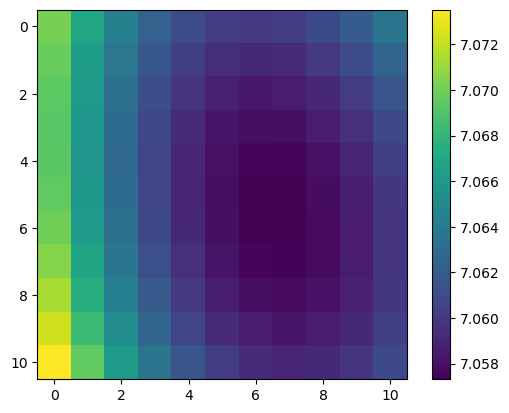

In [138]:
n = 11
log10_t0 = np.linspace(3.98, 4.001, n)
t0 = 10**log10_t0
sigma_t = np.linspace(2.8, 3.5, n)

losses = np.ndarray((n,n))

start = time.time()

for i in range(n):
    for j in range(n):
        #print('hi')
        params = (t0[i], sigma_t[j], 1.6, 't')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(np.log10(losses))
plt.colorbar()
plt.show()

In [141]:
min_ind

(6, 7)

In [140]:
min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_t0 = t0[min_ind[0]]
best_sigma_t = sigma_t[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('T_0 = ' + str(best_t0))
print('sigma_T = ' + str(best_sigma_t))

Minimum loss: 11410698.0

Best values:
T_0 = 9831.0521528177
sigma_T = 3.29


### adjusting gamma

In [ ]:
gammas = np.linspace(1.7, 1.71, 10)
losses = np.empty_like(gammas)

for i in range(len(gammas)):
    losses[i] = obj_fn((3.2, 1.4, gammas[i], 'rho'))
    
plt.plot(losses)
plt.show()

## Plot fitting results

NameError: name 'rho_train' is not defined

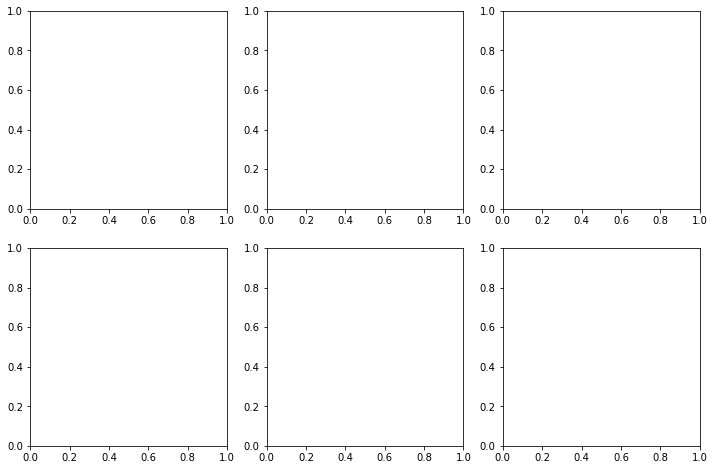

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))

axes[0,0].imshow(np.log(rho_train))
axes[0,0].set_title('log(true rho))')

rho_pred = bary_model(rho_train, best_rho0, best_sigma_rho, 1.6)
axes[0,1].imshow(np.log(rho_pred))
axes[0,1].set_title('log(pred rho))')

axes[0,2].imshow(np.log(np.abs(rho_train - rho_pred)))
axes[0,2].set_title('residuals (rho)')

axes[1,0].imshow(np.log(temp_train))
axes[1,0].set_title('log(true T))')

temp_pred = bary_model(rho_train, best_t0, best_sigma_t, 1.6)
axes[1,1].imshow(np.log(temp_pred))
axes[1,1].set_title('log(pred T))')

axes[1,2].imshow(np.log(np.abs(temp_train - temp_pred)))
axes[1,2].set_title('residuals (T)')

plt.show()

In [170]:
print('Mean loss in rho:', np.mean(np.abs(rho_train - rho_pred)))
print('Mean loss in T:', np.mean(np.abs(temp_train - temp_pred)))

Mean loss in rho: 1.6190977
Mean loss in T: 2168.488


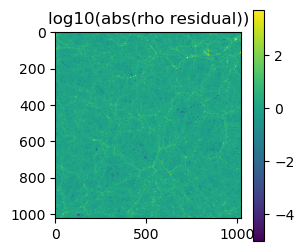

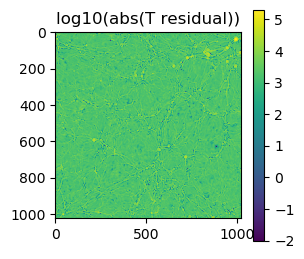

In [167]:
plt.figure(figsize=(3,3))
plt.imshow(np.log10(np.abs(rho_train - rho_pred)))
plt.title('log10(abs(rho residual))')
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(np.abs(temp_train - temp_pred)))
plt.title('log10(abs(T residual))')
plt.colorbar()
plt.show()

# Perform optimization

When we feed the input $\rho$ into the model, it returns the output $\tau_{real}$. Let the input have shape [x,y,z].

Outline:
- Define a variable x that's the same as the input but with an extra dimension added (so it has shape [x,y,z,1]).
- The loss function `loss_fn` is `keras.metrics.mean_squared_error(model(x[...,0])[...,None], treal_true[...,None])`. The result has shape [x,y,z].
- Compute the loss and gradients of `loss_fn` via: `loss_and_grads = lambda x: tfp.math.value_and_gradient(loss_fn, x)`. The loss array has shape [x,y,z], while the gradient array has shape [x,y,z,1].
- Define the optimizer: `optim = tfp.optimizer.lbfgs_minimize(loss_and_grads, initial_position=x)`. Right now, this runs into a shape mismatch error. It gets through one iteration without problems, so maybe there's an issue with updating x?

## LBFGS example

In [21]:
# A high-dimensional quadratic bowl.
ndims = 60
minimum = np.ones([ndims], dtype='float64')
#scales = np.arange(ndims, dtype='float64') + 1.0

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
    return tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(tf.math.squared_difference(x, minimum), axis=-1),
            x)
start = np.arange(ndims, 0, -1, dtype='float64')
start = np.reshape(start, [ndims])
print('start:', start)
print('starting (loss,grad):', quadratic_loss_and_gradient(start))
optim_results = tfp.optimizer.lbfgs_minimize(
  quadratic_loss_and_gradient,
  initial_position=start,
  num_correction_pairs=10,
  tolerance=1e-8)

start: [60. 59. 58. 57. 56. 55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43.
 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.  2.  1.]
starting (loss,grad): (<tf.Tensor: shape=(), dtype=float32, numpy=70210.0>, <tf.Tensor: shape=(60,), dtype=float32, numpy=
array([118., 116., 114., 112., 110., 108., 106., 104., 102., 100.,  98.,
        96.,  94.,  92.,  90.,  88.,  86.,  84.,  82.,  80.,  78.,  76.,
        74.,  72.,  70.,  68.,  66.,  64.,  62.,  60.,  58.,  56.,  54.,
        52.,  50.,  48.,  46.,  44.,  42.,  40.,  38.,  36.,  34.,  32.,
        30.,  28.,  26.,  24.,  22.,  20.,  18.,  16.,  14.,  12.,  10.,
         8.,   6.,   4.,   2.,   0.], dtype=float32)>)


In [22]:
#tf.reduce_sum(
tf.math.squared_difference(start, minimum)#, axis=-1)

<tf.Tensor: shape=(60,), dtype=float64, numpy=
array([3.481e+03, 3.364e+03, 3.249e+03, 3.136e+03, 3.025e+03, 2.916e+03,
       2.809e+03, 2.704e+03, 2.601e+03, 2.500e+03, 2.401e+03, 2.304e+03,
       2.209e+03, 2.116e+03, 2.025e+03, 1.936e+03, 1.849e+03, 1.764e+03,
       1.681e+03, 1.600e+03, 1.521e+03, 1.444e+03, 1.369e+03, 1.296e+03,
       1.225e+03, 1.156e+03, 1.089e+03, 1.024e+03, 9.610e+02, 9.000e+02,
       8.410e+02, 7.840e+02, 7.290e+02, 6.760e+02, 6.250e+02, 5.760e+02,
       5.290e+02, 4.840e+02, 4.410e+02, 4.000e+02, 3.610e+02, 3.240e+02,
       2.890e+02, 2.560e+02, 2.250e+02, 1.960e+02, 1.690e+02, 1.440e+02,
       1.210e+02, 1.000e+02, 8.100e+01, 6.400e+01, 4.900e+01, 3.600e+01,
       2.500e+01, 1.600e+01, 9.000e+00, 4.000e+00, 1.000e+00, 0.000e+00])>

In [24]:
import eos
import grid
import snapshot

from spectrum import gmlt_spec_od_grid

In [25]:
## take a few skewers
shape = [1, 1, 1024]
size = [21.09375 / 1024 * x for x in shape]
inds = (slice(0, shape[0]), slice(0, shape[1]), slice(0, shape[2]))
rho_true = DM_dens[inds]
treal_true = treal[inds]

# expand dimensions if shape is (1024,)
# rho_true = rho_true[None, None, :]
# treal_true = treal_true[None, None, :]

## load in snapshot properties
filename = "../..//sim2_z3_FGPA_cgs.h5"
snap = snapshot.Snapshot(filename)

a = snap.scale_factor
z = snap.z
u = snap.universe
h = u.h
omega_b = u.omega_b

## define eos object
rho_crit_100_cgs = 1.8788200386793017e-29
mean_rhob_cgs = omega_b * h*h * rho_crit_100_cgs
a3_inv = 1.0 / (a * a * a)
rhob_cgs_conversion = mean_rhob_cgs * a3_inv

eos_obj = eos.EOS_at_z(z, rhob_cgs_conversion)

In [26]:
treal_true.shape

(1, 1, 1024)

In [27]:
rho_true.shape

(1, 1, 1024)

In [28]:
## create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal(shape, 0, 0.5, tf.float64, seed=1)
rho_pred = tf.Variable(10**log10_noise)

## define the model; parameters taken from attempt 1
rho_0, sigma_rho, gamma_rho = 1.15997566, 3.3063766, 1.89804891
T_0, sigma_T, gamma_T = 1.23905759e+04, 4.00657396e+00, 1.46157072e+00

def model(rho_pred):
    # get rho and T skewers from analytical formulas
    rhob = rho_0 * (gaussian_blur(rho_pred, sigma_rho*2, sigma_rho))**(gamma_rho - 1)
    temp = T_0 * (gaussian_blur(rho_pred, sigma_T*2, sigma_T))**(gamma_T - 1)
    rhob = tf.squeeze(rhob, axis=-1) # remove the last dimension
    temp = tf.squeeze(temp, axis=-1)
        
    # get the n_hi grid via eos object
    log10_rhob = tf.math.log(rhob) / np.log(10)
    log10_temp = tf.math.log(temp) / np.log(10)
    nhi_field = eos_obj.compute_nhi(log10_rhob, log10_temp)
    nhi = grid.Grid(nhi_field, shape, size)
    
    # get real-space optical depth
    vpara = np.zeros(shape)
    treal_pred = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
                nhi.field, temp, vpara, shape[2])
        
    return treal_pred.field

In [29]:
# check that the model works
treal = model(rho_pred)
print(treal)

2021-09-18 00:47:42.239095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-18 00:47:42.512841: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x564d9cc0b5e0


tf.Tensor([[[0.3304299  0.31510356 0.30221588 ... 0.36714903 0.35895105 0.34583476]]], shape=(1, 1, 1024), dtype=float64)


**From the docs for tfp.optimizer.lbfgs_minimize:**

The input to loss_and_grads should have "shape [..., n], where n is the size of the domain of input points, and all others are batching dimensions. The first component of the return value [of loss_and_grads] is a real Tensor of matching shape [...]. The second component (the gradient) is also of shape [..., n] like the input value to the function."

In [30]:
model(rho_pred)

<tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=
array([[[0.3304299 , 0.31510356, 0.30221588, ..., 0.36714903,
         0.35895105, 0.34583476]]])>

In [31]:

import contextlib
import functools
import os


In [37]:
loss_and_grads(start)

(<tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=
 array([[[0.06924376, 0.06073837, 0.05475937, ..., 0.09570973,
          0.0886502 , 0.07909549]]])>,
 <tf.Tensor: shape=(1, 1, 1024, 1), dtype=float64, numpy=
 array([[[[0.07677604],
          [0.09834884],
          [0.11930764],
          ...,
          [0.09557616],
          [0.08312532],
          [0.06741814]]]])>)

In [57]:
tt = treal_true[0,0]

In [62]:
loss_fn = lambda x: \
    keras.metrics.mean_squared_error(model(x[None,None,...])[0,0], tt)


In [68]:
start = rho_pred[0,0]
print(start.shape)

(1024,)


In [69]:
loss_and_grads = lambda x: tfp.math.value_and_gradient(loss_fn, x)


In [70]:
loss_and_grads(start)

(<tf.Tensor: shape=(), dtype=float64, numpy=291.1807919466055>,
 <tf.Tensor: shape=(1024,), dtype=float64, numpy=
 array([7.49765980e-05, 9.60437891e-05, 1.16511371e-04, ...,
        9.33360952e-05, 8.11770656e-05, 6.58380256e-05])>)

In [ ]:
# loss function
#mse = keras.losses.MeanSquaredError() # this sums all losses
#mse = keras.metrics.mean_squared_error() # this has the same shape as the inputs

# x is the predicted rho with shape [x,y,z,1]
# loss_fn = lambda x: \
#     keras.metrics.mean_squared_error(model(x[...,0])[...,None], treal_true[...,None])
#loss_fn = lambda x: \
#    keras.metrics.mean_squared_error(model(x[...,0])[...,None], treal_true[...,None])

# compute both loss_fn and its gradients wrt x
loss_and_grads = lambda x: tfp.math.value_and_gradient(loss_fn, x)

def loss_and_grads(x):
    val, grad = tfp.math.value_and_gradient(loss_fn, x)
    return (val[:,:,:,None],grad[:,:,:,:])

In [98]:
# optimizer
#optim = tf.optimizers.Adam(learning_rate=0.1)
#start = rho_pred[...,None]
optim = tfp.optimizer.lbfgs_minimize(loss_and_grads, \
                                     initial_position=start,max_iterations=5000)


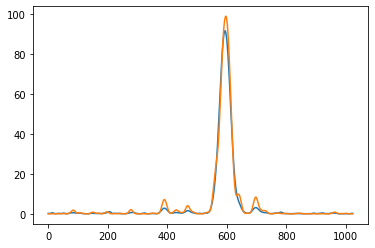

In [99]:
plt.plot(model(optim.position[None,None,...])[0,0])
plt.plot(tt)

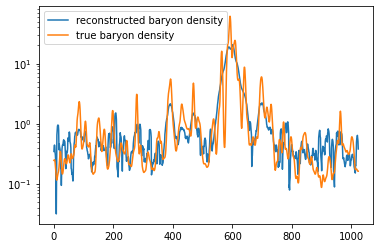

In [102]:
#plt.plot(optim.position[None,None,...][0,0])
rhob_t = rho_0 * (gaussian_blur(optim.position[None,None,...], sigma_rho*2, sigma_rho))**(gamma_rho - 1)
plt.plot(rhob_t[0,0,...,0],label="reconstructed baryon density")

plt.plot(rhob_test,label="true baryon density")
plt.semilogy()
plt.legend()


In [28]:

def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad


@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)


def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

In [29]:
@make_val_and_grad_fn
def quadratic(x):
  return tf.reduce_sum((model(x)- treal_true)**2.0,axis=-1)


In [30]:
tf.reduce_sum((rho_pred**2.0- treal_true)**2.0,axis=-1)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2853917.96267439]])>

In [80]:
tf.Variable(log10_noise)

<tf.Variable 'Variable:0' shape=(1, 1, 1024) dtype=float64, numpy=
array([[[ 0.68500758, -0.82542105,  0.09882153, ...,  0.09782097,
         -0.54839792,  0.5176168 ]]])>

In [78]:
rho_pred = tf.Variable(log10_noise)

tolerance = 1e-10
@make_val_and_grad_fn
def quadratic(x):
  return tf.reduce_sum((model(x)- treal_true)**2.0,axis=-1)[0]

print(quadratic(rho_pred))

@tf.function
def quadratic_with_lbfgs():
  return tfp.optimizer.lbfgs_minimize(
    quadratic,
    initial_position=rho_pred[0],
    tolerance=tolerance)

results = run(quadratic_with_lbfgs)


(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([nan])>, <tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=array([[[nan, nan, nan, ..., nan, nan, nan]]])>)


NotImplementedError: in user code:

    /tmp/ipykernel_98161/1658931682.py:13 quadratic_with_lbfgs  *
        quadratic,
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/optimizer/lbfgs.py:280 minimize  **
        tolerance)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/optimizer/lbfgs.py:299 _get_initial_state
        tolerance)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/optimizer/bfgs_utils.py:81 get_initial_state_args
        f0, df0 = value_and_gradients_function(initial_position)
    /tmp/ipykernel_98161/2515837771.py:4 val_and_grad
        return tfp.math.value_and_gradient(value_fn, x)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/math/gradient.py:112 value_and_gradient
        **kwargs)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/math/gradient.py:334 _value_and_grad_impl
        output_gradients)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/math/gradient.py:291 _gradient_old
        y = f()
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow_probability/python/math/gradient.py:332 <lambda>
        y, dydx = grad_fn(lambda: f(*args, **kwargs) if _has_args(f) else f(),
    /tmp/ipykernel_98161/1658931682.py:6 quadratic
        return tf.reduce_sum((model(x)- treal_true)**2.0,axis=-1)[0]
    /tmp/ipykernel_98161/2399905389.py:20 model
        nhi_field = eos_obj.compute_nhi(log10_rhob, log10_temp)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/custom_gradient.py:309 __call__
        return self._d(self._f, a, k)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/custom_gradient.py:265 decorated
        return _graph_mode_decorator(wrapped, args, kwargs)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/ops/custom_gradient.py:382 _graph_mode_decorator
        result, grad_fn = f(*args)
    /home/ben.horowitz/lya-tf/lya_fields/eos.py:130 compute_nhi
        nhi = self.n(log10_rhob, log10_temp, grid=False) # this is a 3D ndarray
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:897 __call__
        x = np.asarray(x)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /home/ben.horowitz/miniconda3/envs/lya-tf/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:870 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (minimize/value_and_gradient/truediv_4:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [93]:
rho_pred = tf.Variable(log10_noise)#tf.Variable(10**log10_noise)

tolerance = 1e-10
@make_val_and_grad_fn
def quadratic(x):
  return tf.reduce_sum((model(tf.math.pow(10,x))- treal_true)**2.0,axis=-1)[0]

f = quadratic(rho_pred)
print(f)

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([298169.13189926])>, <tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=
array([[[0.85595071, 0.03385039, 0.3449096 , ..., 0.2756678 ,
         0.05414407, 0.51122143]]])>)


In [96]:
model(tf.math.pow(10,rho_pred-f[1]))

<tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=
array([[[0.01668608, 0.01541741, 0.01451568, ..., 0.02279498,
         0.02052257, 0.01840854]]])>

In [ ]:
#update = f[1]*0.001
for i in range(0,10000):
    f1 = quadratic(rho_pred -update)
    update += f1[1]*float(0.0001/np.sqrt(i+1))
    print(i,f1[0])

0 tf.Tensor([9576.80822104], shape=(1,), dtype=float64)
1 tf.Tensor([9367.89989591], shape=(1,), dtype=float64)
2 tf.Tensor([9235.72415145], shape=(1,), dtype=float64)
3 tf.Tensor([9134.14358875], shape=(1,), dtype=float64)
4 tf.Tensor([9051.14975108], shape=(1,), dtype=float64)
5 tf.Tensor([8979.98773985], shape=(1,), dtype=float64)
6 tf.Tensor([8917.52317833], shape=(1,), dtype=float64)
7 tf.Tensor([8861.53868846], shape=(1,), dtype=float64)
8 tf.Tensor([8810.71634574], shape=(1,), dtype=float64)
9 tf.Tensor([8764.03444502], shape=(1,), dtype=float64)
10 tf.Tensor([8720.79153153], shape=(1,), dtype=float64)
11 tf.Tensor([8680.4358884], shape=(1,), dtype=float64)
12 tf.Tensor([8642.54587991], shape=(1,), dtype=float64)
13 tf.Tensor([8606.78447823], shape=(1,), dtype=float64)
14 tf.Tensor([8572.87957086], shape=(1,), dtype=float64)
15 tf.Tensor([8540.60761671], shape=(1,), dtype=float64)
16 tf.Tensor([8509.78276522], shape=(1,), dtype=float64)
17 tf.Tensor([8480.24864793], shape=(1,), 

In [121]:
from scipy import ndimage

In [155]:
pred = rho_0 * (gaussian_blur(10**(rho_pred-update), sigma_rho*2, sigma_rho))**(gamma_rho - 1)

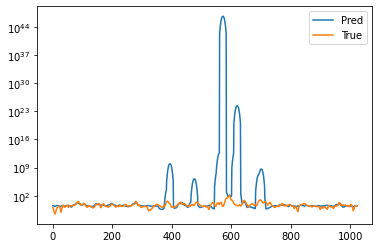

In [156]:
plt.semilogy(ndimage.gaussian_filter1d(pred[0,0,:,0],2),label="Pred")
#plt.plot(rho_pred.numpy()[0,0])
plt.semilogy(ndimage.gaussian_filter1d(rho_true[0,0],2),label="True")
plt.legend()


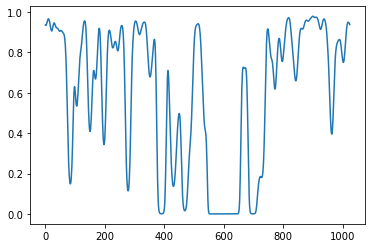

In [163]:
plt.plot(np.exp(-1*treal_true[0,0]))

In [71]:
model(rho_pred - update-f2[1]+0.8192772198071296)

<tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=
array([[[0.39197595, 0.37058014, 0.35119585, ..., 0.44212896,
         0.43026738, 0.4127055 ]]])>

In [70]:
np.array(rho_pred - update-f2[1]).min()

-0.8192772198071296

In [63]:
quadratic(rho_pred - update-f2[1])

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([nan])>,
 <tf.Tensor: shape=(1, 1, 1024), dtype=float64, numpy=array([[[nan, nan, nan, ..., nan, nan, nan]]])>)

[LBFGS not working with tensorflow 2.0](https://github.com/tensorflow/probability/issues/398)

In [ ]:
# TODO: replicate results with Gimlet's tau_real
# ...

# Plot reconstruction results

In [ ]:
# true and predicted log(input)
plt.figure(figsize=(10,4))

plt.plot(np.log10(rho_true), color='black', label='log10(rho) (true)')
plt.plot(np.log10(rho_pred), 'blue', label = 'log10(rho) (pred)', alpha=0.5)
plt.title('log10(rho)')
plt.ylim(-5, 3)
plt.legend()
plt.show()

# true and predicted "data"
plt.figure(figsize=(10,4))
plt.plot(treal_true, color='black', label='tau_real (true)')
plt.plot(treal_pred_final, 'blue', label = 'tau_real (pred)', alpha=0.5)
plt.title('tau_real')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(10,4))
plt.plot(np.log10(losses))
plt.title('log10(loss)')
plt.show()